# Examples of calibration with dynamic state and parameter interventions

### Load dependencies

In [1]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Callable

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

# Select data and model, set parameters for sampling

Data date range: October 28, 2021 - December 28, 2021

Data source: Cumulative case and death data from New York Times [COVID-19 Data Github](https://github.com/nytimes/covid-19-data)

In [2]:
data = "LA_county_covid_data.csv"
model = "SEIRHD_vacc_petrinet.json"

start_time = 0.0
end_time = 80.0 # simulate from 10/28/2021 to 01/16/2022
logging_step_size = 1.0
num_samples = 100
num_iterations = 101

# Calibrate and simulate with `dynamic_parameter_interventions`

## Set up and perform calibration where the dynamic intervention has a fixed value

Intervention: when deaths reach 25,500, change the transmission rate `beta` to 0.05.

In [3]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold
    return var_threshold
    
infection_threshold = make_var_threshold("D", torch.tensor(25500.0))
dynamic_parameter_interventions1 = {infection_threshold: {"beta": torch.tensor(0.05)}}


# Perform calibration
data_mapping = {"cases": "cumulative_cases", "deaths": "deceased"} # data is mapped to observables
calibrated_results = pyciemss.calibrate(
    model, 
    data, 
    data_mapping=data_mapping, 
    dynamic_parameter_interventions=dynamic_parameter_interventions1,
    num_iterations=num_iterations,
    verbose=True
)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 61 rows of data. The first column, Timestamp, begins at 0 and ends at 61. The subsequent columns are named: cases, deaths
iteration 0: loss = 1368.6939573287964
iteration 25: loss = 1361.0520300865173
iteration 50: loss = 1351.6255645751953
iteration 75: loss = 1352.9078562259674
iteration 100: loss = 1348.3993651866913


{'persistent_NPI_mult': tensor(0.9994, grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1243, grad_fn=<ExpandBackward0>),
 'persistent_r_Sv': tensor(9999.8398, grad_fn=<ExpandBackward0>),
 'persistent_r_EI': tensor(0.2241, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_u': tensor(0.0044, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_v': tensor(0.0010, grad_fn=<ExpandBackward0>),
 'persistent_r_HR': tensor(0.1245, grad_fn=<ExpandBackward0>),
 'persistent_r_HD': tensor(0.0106, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_u': tensor(0.1533, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_v': tensor(0.1796, grad_fn=<ExpandBackward0>)}

## Sample the calibrated model with `dynamic_parameter_interventions`

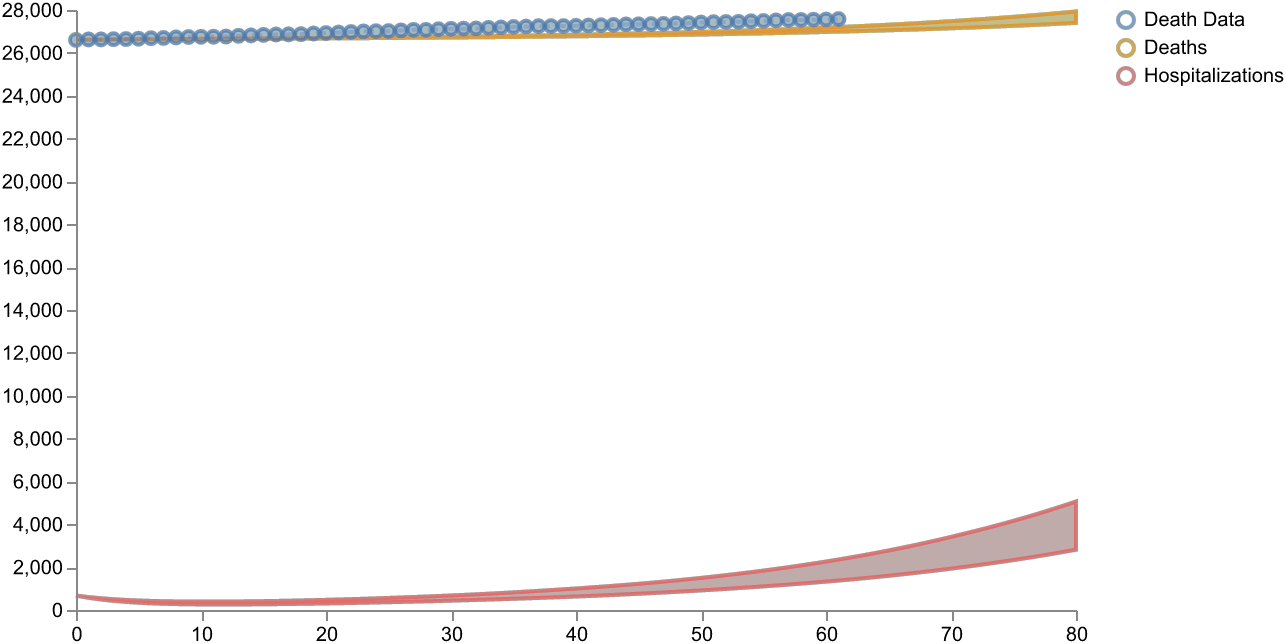

In [4]:
calibrated_sample_results = pyciemss.sample(
    model, 
    end_time, 
    logging_step_size, 
    num_samples,             
    start_time=start_time, 
    inferred_parameters=parameter_estimates,
    dynamic_parameter_interventions=dynamic_parameter_interventions1,
)

# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations",
        "deceased_observable_state": "Deaths",
        }
nice_data_names = {
        "deaths": "Death Data"
        }
data_df = pd.read_csv(data)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["hospitalized_observable_state", "deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', 'cases']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Set up and perform calibration where the dynamic intervention has uncertainty (as in, the parameter takes on a value that is a function of the original uncertain parameter)

Intervention: when deaths reach 25,500, reduce the transmission rate to half its original (calibrate and unintervened) value.

In [5]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold
    return var_threshold
    
infection_threshold = make_var_threshold("D", torch.tensor(25500.0))
dynamic_parameter_interventions1 = {infection_threshold: {"beta": lambda x : 0.5*x}}


# Perform calibration
data_mapping = {"cases": "cumulative_cases", "deaths": "deceased"} # data is mapped to observables
calibrated_results = pyciemss.calibrate(
    model, 
    data, 
    data_mapping=data_mapping, 
    dynamic_parameter_interventions=dynamic_parameter_interventions1,
    num_iterations=num_iterations,
    verbose=True
)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 61 rows of data. The first column, Timestamp, begins at 0 and ends at 61. The subsequent columns are named: cases, deaths
iteration 0: loss = 1371.226666212082
iteration 25: loss = 1364.218694806099
iteration 50: loss = 1356.3224511146545
iteration 75: loss = 1351.4435151815414
iteration 100: loss = 1346.7178577184677


{'persistent_NPI_mult': tensor(0.9994, grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1307, grad_fn=<ExpandBackward0>),
 'persistent_r_Sv': tensor(9999.2773, grad_fn=<ExpandBackward0>),
 'persistent_r_EI': tensor(0.1508, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_u': tensor(0.0041, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_v': tensor(0.0011, grad_fn=<ExpandBackward0>),
 'persistent_r_HR': tensor(0.1753, grad_fn=<ExpandBackward0>),
 'persistent_r_HD': tensor(0.0112, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_u': tensor(0.1554, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_v': tensor(0.1671, grad_fn=<ExpandBackward0>)}

## Sample the calibrated model with uncertain `dynamic_parameter_interventions`

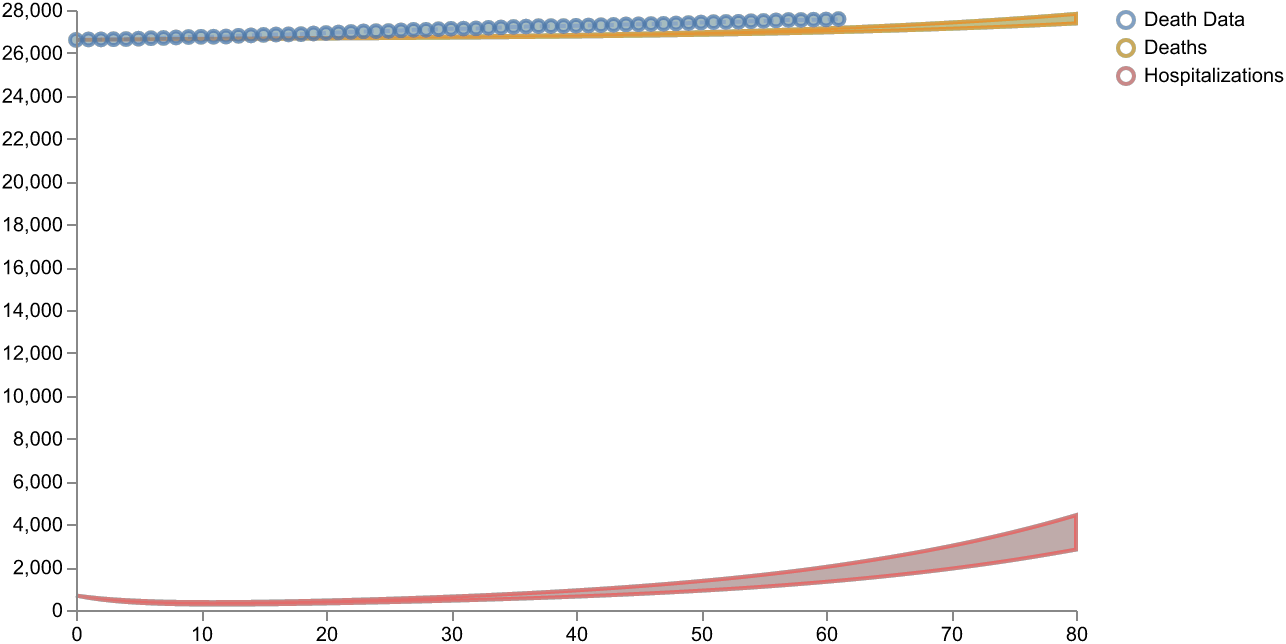

In [6]:
calibrated_sample_results = pyciemss.sample(
    model, 
    end_time, 
    logging_step_size, 
    num_samples,             
    start_time=start_time, 
    inferred_parameters=parameter_estimates,
    dynamic_parameter_interventions=dynamic_parameter_interventions1,
)

# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations",
        "deceased_observable_state": "Deaths",
        }
nice_data_names = {
        "deaths": "Death Data"
        }
data_df = pd.read_csv(data)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["hospitalized_observable_state", "deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', 'cases']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Calibrate and simulate with `dynamic_state_interventions`

## Set up and perform calibration with `dynamic_state_interventions`

Intervention: when hospitalizations reach 1000, move 500 hospitalized people to the susceptible-unvaccinated state.

In [7]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    def var_threshold(time, state):
        return state[var] - threshold  
    return var_threshold
    
infection_threshold = make_var_threshold("H", torch.tensor(1000.0))
dynamic_state_interventions1 = {infection_threshold: {"H": torch.tensor(500.0),
                                                      "S_u": lambda x: x + 500.0,
                                                     }} 

# Perform calibration
data_mapping = {"cases": "cumulative_cases", "deaths": "deceased"} # data is mapped to observables
calibrated_results = pyciemss.calibrate(
    model, 
    data, 
    data_mapping=data_mapping, 
    dynamic_state_interventions=dynamic_state_interventions1,
    num_iterations=num_iterations,
    verbose=True
)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 61 rows of data. The first column, Timestamp, begins at 0 and ends at 61. The subsequent columns are named: cases, deaths
iteration 0: loss = 1370.8547308444977
iteration 25: loss = 1362.4700849056244
iteration 50: loss = 1356.5253670215607
iteration 75: loss = 1350.2772498130798
iteration 100: loss = 1351.9454072713852


{'persistent_NPI_mult': tensor(1.0009, grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1332, grad_fn=<ExpandBackward0>),
 'persistent_r_Sv': tensor(10000.2578, grad_fn=<ExpandBackward0>),
 'persistent_r_EI': tensor(0.2083, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_u': tensor(0.0041, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_v': tensor(0.0012, grad_fn=<ExpandBackward0>),
 'persistent_r_HR': tensor(0.1206, grad_fn=<ExpandBackward0>),
 'persistent_r_HD': tensor(0.0107, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_u': tensor(0.1027, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_v': tensor(0.1536, grad_fn=<ExpandBackward0>)}

## Sample the calibrated model with `dynamic_state_interventions`

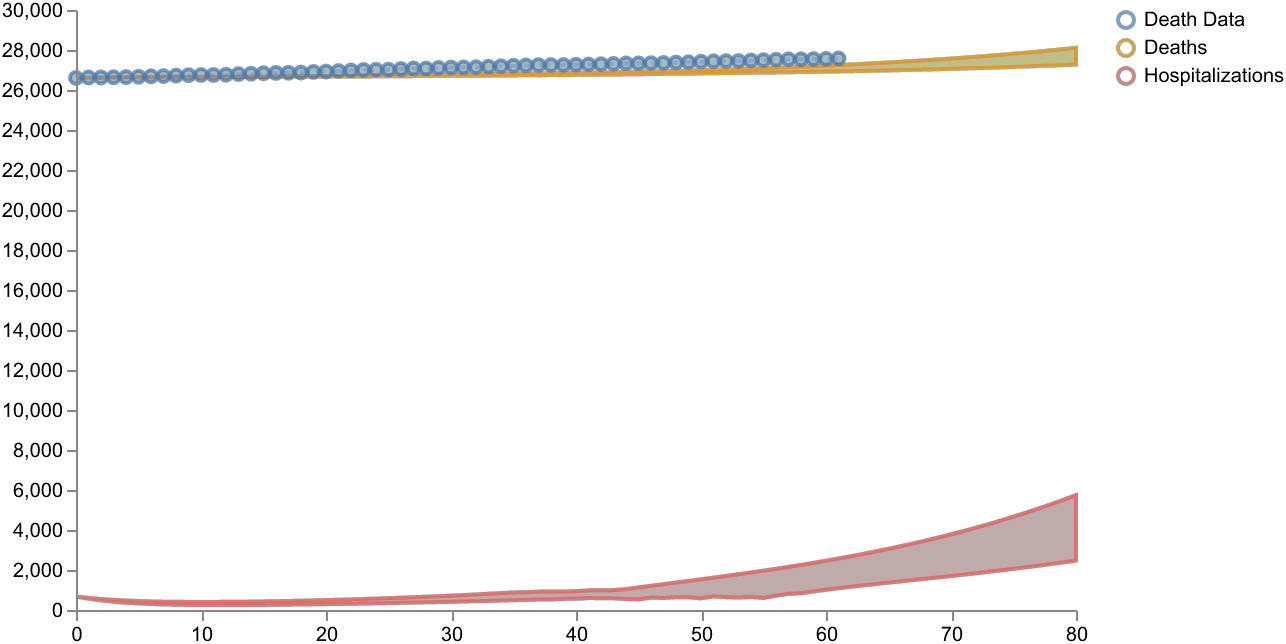

In [8]:
calibrated_sample_results = pyciemss.sample(
    model, 
    end_time, 
    logging_step_size, 
    num_samples,             
    start_time=start_time, 
    inferred_parameters=parameter_estimates,
    dynamic_state_interventions=dynamic_state_interventions1,
)

# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations",
        "deceased_observable_state": "Deaths",
        }
nice_data_names = {
        "deaths": "Death Data"
        }
data_df = pd.read_csv(data)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["hospitalized_observable_state", "deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp', 'cases']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

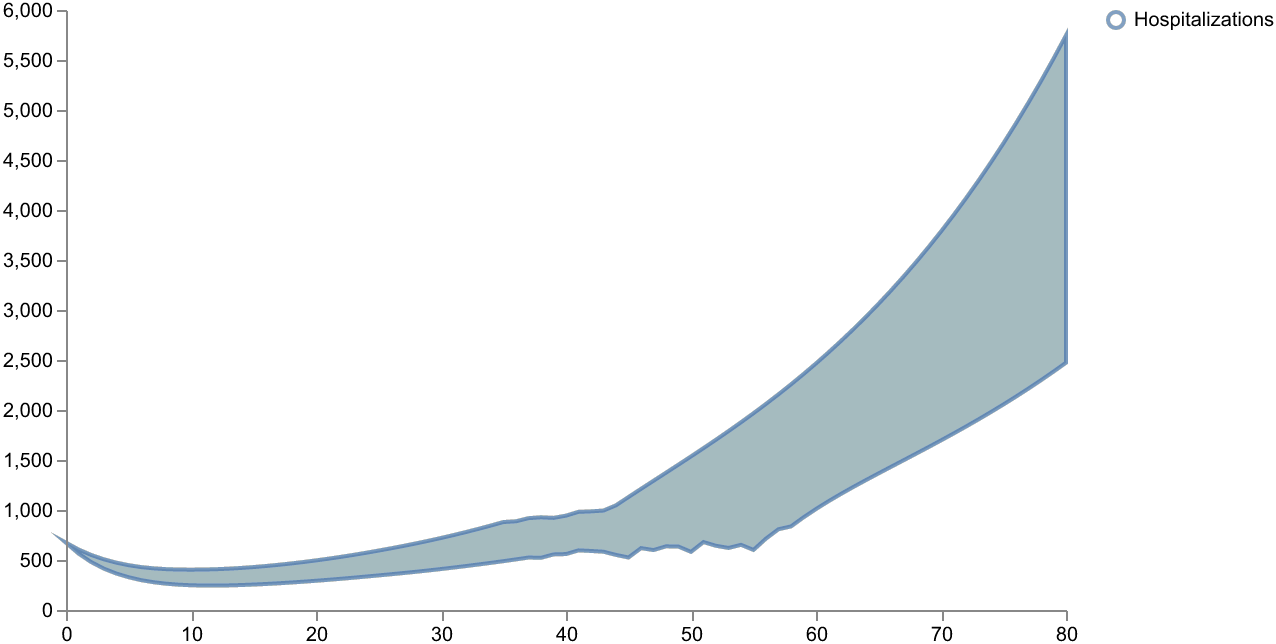

In [10]:
# Plot the result
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations",
        }
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep="hospitalized_observable_state", 
    relabel=nice_labels,
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)